<center><h1 style="font-size:40px;">Image Classification using CNNs</h1></center>

Welcome to the *Fourth* lab for Deep Learning!

In this lab an CNN network to classify RGB images. Image classification refers to classify classes from images. This labs the *dataset* consist of multiple images where each image have a target label for classification.

Good luck!


In [1]:
import torch
from torch import nn
import os
import imageio
import torchvision
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import OrderedDict
import imageio.v2 as imageio
import torchvision.transforms as transforms
from PIL import Image
from torchvision.datasets import ImageFolder
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np

### In case you have uploaded a zip file unzip it first. 

Then lets define the ```path``` to the dataset. Make sure you explore the directories of the dataset and get familiar with it!

In [2]:
training_img_dir = "../data/FlyingObjectDataset_10K/training"
validation_img_dir = "../data/FlyingObjectDataset_10K/validation"
testing_img_dir = "../data/FlyingObjectDataset_10K/testing"

Optionally we will start using ```tensorboard```. Use of tensorboard is optional, but we recommend the students to use it. 

In [3]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/classification_1') #make sure to adapt this to your needs

In [4]:
dummy_train_loss, _ = torch.sort(torch.rand(100) * 5, descending=True)
dummy_val_loss, _ = torch.sort(torch.rand(100) * 6, descending=True )
dummy_train_acc, _ = torch.sort(torch.rand(100) * 100)
dummy_val_acc, _ = torch.sort(torch.rand(100) * 80)
for i in range(100): 
    writer.add_scalar('Loss/Train', dummy_train_loss[i], i)
    writer.add_scalar('Loss/Val', dummy_val_loss[i], i)
    writer.add_scalar('Acc/Train', dummy_train_acc[i], i)
    writer.add_scalar('Acc/Val', dummy_val_acc[i], i)


Please make sure to read the [doc](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) to understand how to correctly plot your ```losses``` and ```metrics``` to tensorboard

Ok now that we have the path to the tree different splits, lets start by defining our ```Dataset``` class!
The main two methods we need to define when subclassing ```Dataset``` is ```__getitem__``` and ```__len__```:

In [5]:
class FlyingObjects(torch.utils.data.Dataset):
    """Dataset to Flying Object Dataset for the classification task.
       The label information is encoded on the filename, __extract_label will extract the label following the chosen granularity
    
    """
    def __init__(self, root,fine_grained=False,transform=None):
        super(FlyingObjects,self).__init__()
        self.root = root
        self.transform = transform
        self.fine_grained = fine_grained

        self.images = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(self.root+'/image')) for f in fn if f.endswith(".png")]
        self.images.sort()
        
        self.classes = [
            'square_red',
            'square_green',
            'square_blue',
            'square_yellow',
            'triangle_red',
            'triangle_green',
            'triangle_blue',
            'triangle_yellow',
            'circular_red',
            'circular_green',
            'circular_blue',
            'circular_yellow'
        ] if self.fine_grained else [
            'square',
            'triangle',
            'circular',
            'background']
        self.labels = [self.__extract_label(f) for f in self.images]
    

    def get_classes(self):
        return self.classes
    
    
    def __extract_label(self, image_file):
        """Extract label from image_file name"""
        path, img_name = os.path.split(image_file)
        names = img_name.split(".")[0].split("_")

        currLabel = names[1] + "_" + names[2] if self.fine_grained else names[1]

        if currLabel in self.classes:
            label = self.classes.index(currLabel)
        else:
            raise ValueError("ERROR: Label " + str(currLabel) + " is not defined!")
        return label
    
    def __getitem__(self, index):
        # get data
        x = imageio.imread(self.images[index])
        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(x)
        x = x.float()
   
        # get label
        y = self.labels[index]
        #y = np.eye(len(self.get_classes()))[y]
        #y = torch.tensor(y)
        return x, y

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # get data
        x = imageio.imread(self.images[index])
        x = Image.fromarray(x)  # Convert to PIL Image
        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(np.array(x)).float()

        # get label
        y = self.labels[index]
        return x, y

We can define our transformations. Note that not all transformations are considered ```Data Augmentation```.
The following transformations are used to convert our data to ```Tensor``` and resize our images to the desired size!

In [6]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64, 64)), 
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64, 64))
])

# Question 1

Define the three dataloaders for the three splits: ```train```, ```validation``` and ```test``` and visualize data from each split. A function to visualize the image with label is given. You are free to use it or make your own visualizaiton tools.  

In [7]:
def image_with_labels(data, labels, title:str=None, nimages:int=10, nrows:int=2, fig_dimension=1,title_size=10, label_prefix="Label: "):
    """Creates a grid of images with/without labels.

    :param data: tensor": B,W,H,C
    :param labels: tensor":  (Default value = None)
    :param title: str:  (Default value = None)
    :param nimages: int:  (Default value = 10)
    :param nrows: int:  (Default value = 2)
    :param fig_dimension: Default value = 1)
    :param data:"tensor": 
    :param labels:"tensor":  (Default value = None)
    :param title:str:  (Default value = None)
    :param nimages:int:  (Default value = 10)
    :param nrows:int:  (Default value = 2)

    """
    data = data.permute(0,2,3,1)
    image_ratio = data[0].shape[0] /data[0].shape[1]
    if len(data)< nimages:
        nimages = len(data)
 
    columns = math.ceil(nimages/nrows)
    
    if nrows*columns > nimages:
        nrows = math.ceil(nimages/columns)
    
    fig = plt.figure(figsize=(fig_dimension*columns,1.4*fig_dimension*nrows*image_ratio))
    for i in range(0, nimages):
        ax = fig.add_subplot(nrows, columns, i+1)
        ax.imshow(data[i])
        ax.set_xlabel(f"{label_prefix}{labels[i]}") if labels is not None else None
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

    if labels is None:
        fig.suptitle(title,x=0.5, y=.95, size=title_size) 
        
        fig.subplots_adjust(
            left=0,
            right=0.9,
            top=0.9,
            bottom=0,
            wspace=0.1,
            hspace=-0.45
        )
    else:
        fig.suptitle(title) #,x=0.45, y=.95
        
        fig.subplots_adjust(
            #left=0,
            #right=1,
            top=0.9,#+((nrows-1)*0.045),
            #bottom=0,
            wspace=0,
            #hspace=0
        )
        
    #plt.tight_layout(h_pad=0,w_pad=0)
    fig.tight_layout(pad=0, h_pad=0,w_pad=0)
    plt.show()

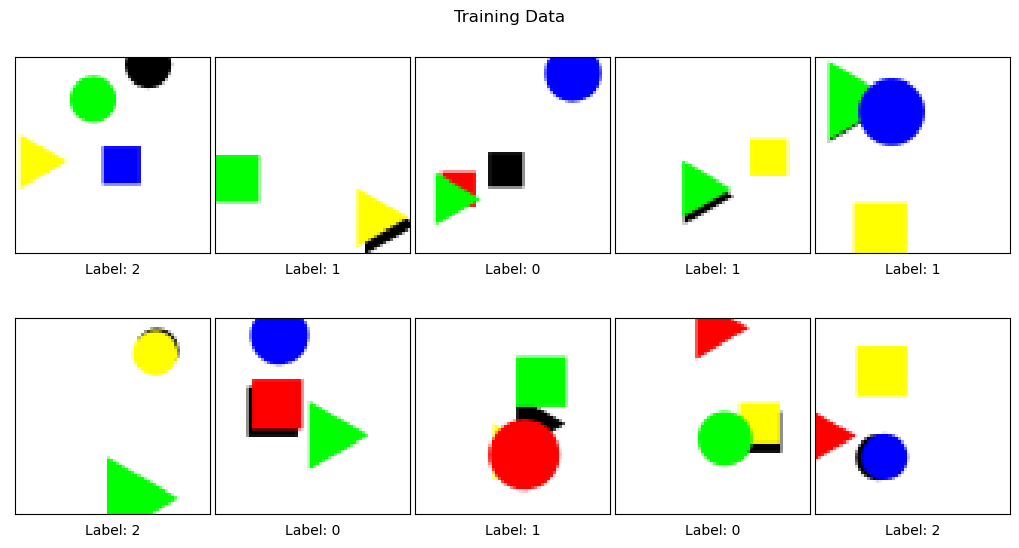

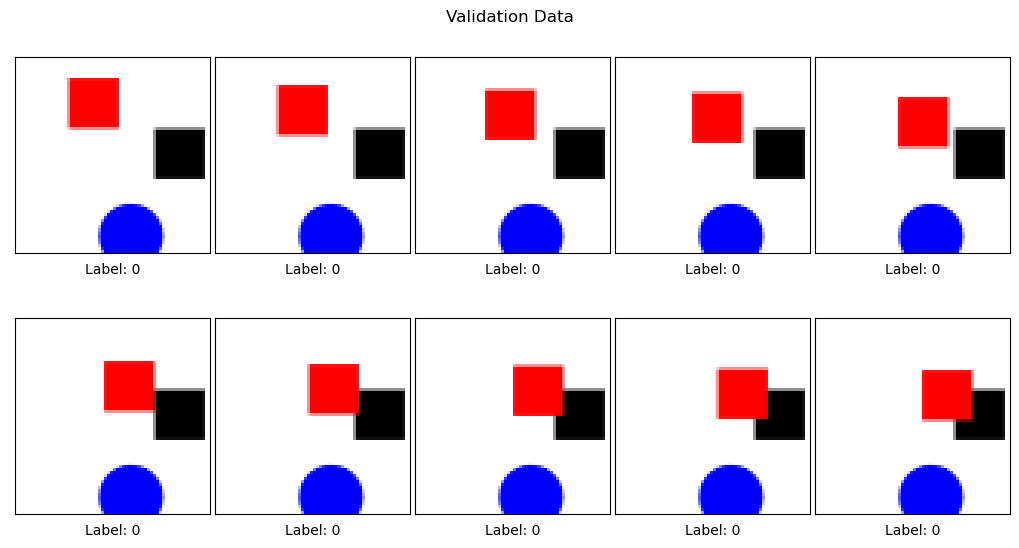

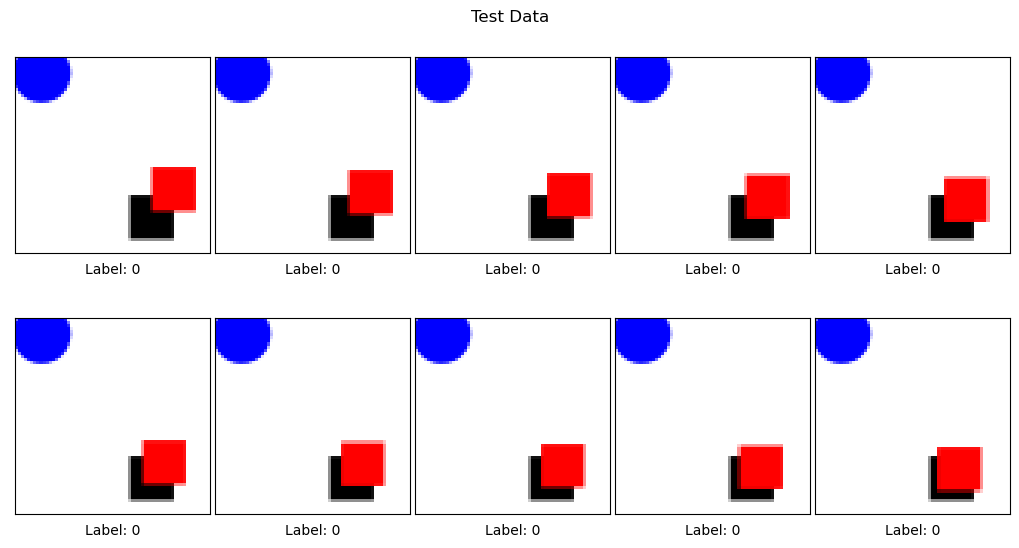

In [8]:
train_dataset = FlyingObjects(training_img_dir, transform=train_transform)
val_dataset = FlyingObjects(validation_img_dir, transform=test_transform)
test_dataset = FlyingObjects(testing_img_dir, transform=test_transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Function to visualize a batch of data
def visualize_data(loader, title):
    data, labels = next(iter(loader))
    image_with_labels(data, labels, title=title, nimages=10, nrows=2, fig_dimension=2, title_size=12)

# Visualize data from each split
visualize_data(train_loader, "Training Data")
visualize_data(val_loader, "Validation Data")
visualize_data(test_loader, "Test Data")

## Let's start with a very simple network

In [9]:
class SimpleModel(torch.nn.Module):
    def __init__(self,num_channels, num_classes, input_shape=(64,64)):
        super(SimpleModel,self).__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(64*input_shape[1]//4*input_shape[1]//4, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
       
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

# Question 2

Get inspired on the code you did on the previous lab and create your ```train function```. It might be useful to think about having a ```predict``` function too. Check the code of the previous lab if you need ideas!

Do not forget, to train you need an ```optimizer```, ```loss function``` and an instance of your ```model```! If you need more inspiration check [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)!

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_channels = 3 
num_classes = len(train_dataset.classes)  

model = SimpleModel(num_channels, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.to(device)
    training_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        training_loss.append(running_loss / len(train_loader))

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        validation_loss.append(running_val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss[-1]}, Validation Loss: {validation_loss[-1]}")

    return training_loss, validation_loss

def predict(model, data_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
    return all_preds

Using device: cuda:0


In [52]:
train_loss, val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
predictions = predict(model, val_loader)  

Using device: cuda:0
Epoch 1/20, Training Loss: 0.47506545420020413, Validation Loss: 2.315391876576567
Epoch 2/20, Training Loss: 0.03344777165699179, Validation Loss: 3.028988882033548
Epoch 3/20, Training Loss: 0.008896347737857718, Validation Loss: 3.529488952155512
Epoch 4/20, Training Loss: 0.009690539890827124, Validation Loss: 4.109387095644168
Epoch 5/20, Training Loss: 0.009201058912694755, Validation Loss: 4.0973454789001975
Epoch 6/20, Training Loss: 0.00817027413136618, Validation Loss: 3.7647021667231155
Epoch 7/20, Training Loss: 0.007569634475997333, Validation Loss: 3.8588371910909314
Epoch 8/20, Training Loss: 0.0007884173971264462, Validation Loss: 3.8312573900749016
Epoch 9/20, Training Loss: 0.004814336039768307, Validation Loss: 4.505085098080035
Epoch 10/20, Training Loss: 0.007231778572253418, Validation Loss: 4.876784321372631
Epoch 11/20, Training Loss: 0.0033651208680288243, Validation Loss: 4.8422845838701924
Epoch 12/20, Training Loss: 0.004837857516025226,

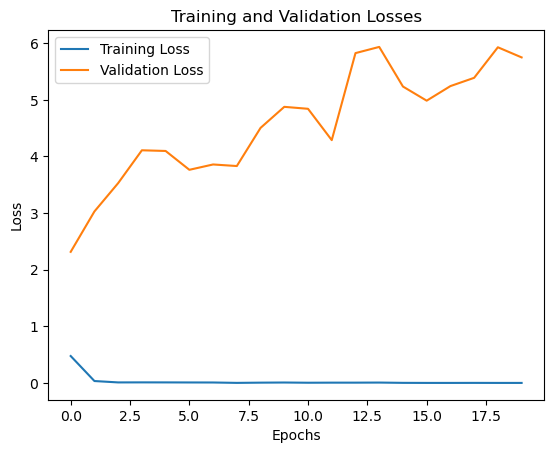

In [55]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Question 3

Now that you have your train function. Train the network until it overfits. Which ```hyperparameters``` allowed you to overfit?

To help you visualize the results we provide a ```confusion matrix function```. 

In [12]:
def matrix(loader, net, classes):
    y_pred = []
    y_true = []
    net.to(device)
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs)
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

    unique_labels = set(y_pred + y_true)
    if len(unique_labels) != len(classes):
        raise ValueError(f"Mismatch in the number of classes: Expected {len(classes)}, but found {len(unique_labels)} unique labels in data.")

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=classes)
    disp.plot()


Epoch 1/50, Training Loss: 0.8245162248314746, Validation Loss: 2.5762648438934597
Epoch 2/50, Training Loss: 0.09514720512576852, Validation Loss: 3.7082391882292325
Epoch 3/50, Training Loss: 0.31938795335661235, Validation Loss: 26.75969040884513
Epoch 4/50, Training Loss: 1.531313260318913, Validation Loss: 16.480576603880166
Epoch 5/50, Training Loss: 0.0772713672255274, Validation Loss: 19.843108765416776
Epoch 6/50, Training Loss: 0.08077633500412792, Validation Loss: 23.110799959427872
Epoch 7/50, Training Loss: 0.08661768579067312, Validation Loss: 37.61648279069053
Epoch 8/50, Training Loss: 0.09840316638796132, Validation Loss: 26.290956318844948
Epoch 9/50, Training Loss: 0.11264463674087571, Validation Loss: 27.514457599274564
Epoch 10/50, Training Loss: 1.1942637682228, Validation Loss: 183.0829978530025
Epoch 11/50, Training Loss: 5.564948733986362, Validation Loss: 144.44582788184496
Epoch 12/50, Training Loss: 0.5887297433804778, Validation Loss: 150.70270641646218
Epo

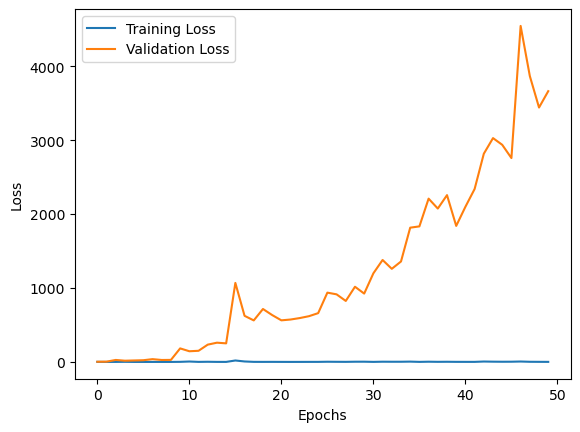

In [58]:
model = SimpleModel(num_channels=3, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  
criterion = nn.CrossEntropyLoss()

train_loss, val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

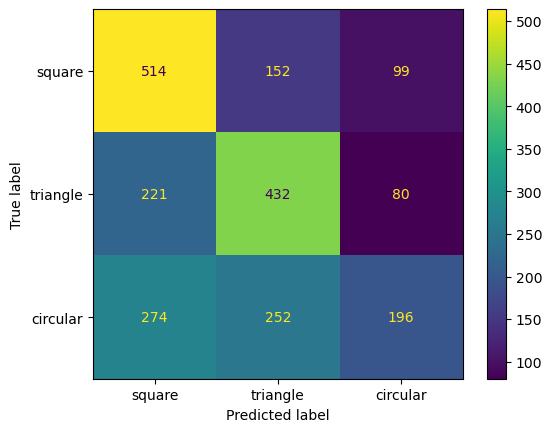

In [64]:
matrix(test_loader,model,['square', 'triangle', 'circular'])

I encreased the number of epochs which lead to overfit!


# Question 4
Go through the [doc](https://pytorch.org/vision/stable/transforms.html) about data augmentation transformations and use some (Try at least 5 augmentations) in your pipeline. Did the ones you try improve your model? Why? 

Along with ```torchvision``` you can also expore ```https://albumentations.ai/``` for advanced augmentation. 

In [13]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

train_dataset_augmented = FlyingObjects(training_img_dir, transform=augmentation_transforms)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  

model = SimpleModel(num_channels, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
train_loss, val_loss = train_and_validate(model, train_loader_augmented, val_loader, criterion, optimizer, num_epochs=40)

Epoch 1/40, Training Loss: 1.1047989564307672, Validation Loss: 1.2348340615420275
Epoch 2/40, Training Loss: 1.041084923399585, Validation Loss: 1.2011727254155655
Epoch 3/40, Training Loss: 0.9263141968433133, Validation Loss: 1.1609286342708158
Epoch 4/40, Training Loss: 0.7618270384087323, Validation Loss: 0.7675508991093702
Epoch 5/40, Training Loss: 0.6558583103625824, Validation Loss: 1.0578809187708187
Epoch 6/40, Training Loss: 0.5741967286016232, Validation Loss: 0.9292461550466611
Epoch 7/40, Training Loss: 0.48624078028321616, Validation Loss: 0.6521273024599921
Epoch 8/40, Training Loss: 0.4289100291234905, Validation Loss: 0.5987869558255778
Epoch 9/40, Training Loss: 0.3839781584992873, Validation Loss: 0.578719704095471
Epoch 10/40, Training Loss: 0.3617889785089676, Validation Loss: 0.8390421097463562
Epoch 11/40, Training Loss: 0.34415513316139035, Validation Loss: 0.5826207312669613
Epoch 12/40, Training Loss: 0.30163058235274304, Validation Loss: 0.40482326080785846

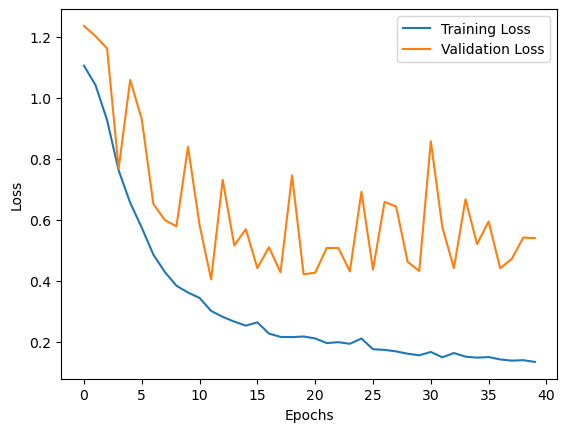

In [16]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

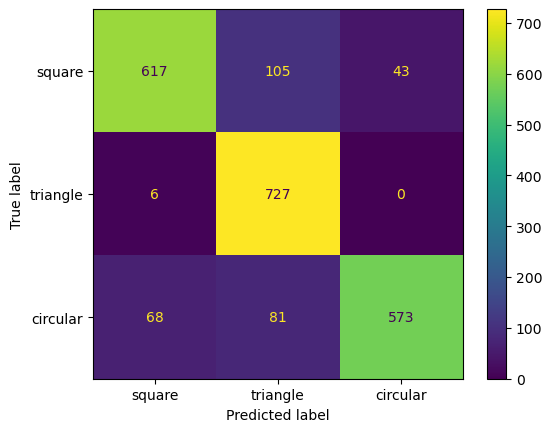

In [17]:
matrix(test_loader,model,['square', 'triangle', 'circular'])

yes seems to be better because validation loss decreases alongside the training loss for a significant number of epochs.

# Question 5

Redo the previous questions with an image size of ```128x128```. Make sure to note what changed and why. If you decided to use tensorboard, compare both versions on ```Tensorboard``` plots.

In [14]:
class SimpleModel(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.to(device)
    training_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        training_loss.append(running_loss / len(train_loader))

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        validation_loss.append(running_val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss[-1]}, Validation Loss: {validation_loss[-1]}")

    return training_loss, validation_loss

In [15]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

train_dataset = FlyingObjects(root= training_img_dir, transform= augmentation_transforms)
val_dataset = FlyingObjects(root= validation_img_dir, transform= augmentation_transforms)
test_dataset = FlyingObjects(root= testing_img_dir, transform= augmentation_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model = SimpleModel(num_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss, val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=40)

Epoch 1/40, Training Loss: 1.1853071991135091, Validation Loss: 1.1033582554923163
Epoch 2/40, Training Loss: 1.107725604842691, Validation Loss: 1.1057896845870547
Epoch 3/40, Training Loss: 1.0975137570325066, Validation Loss: 1.1221171882417467
Epoch 4/40, Training Loss: 1.0932963735917036, Validation Loss: 1.1228598571485944
Epoch 5/40, Training Loss: 1.0790775639169357, Validation Loss: 1.1813185628917482
Epoch 6/40, Training Loss: 1.0608887746053584, Validation Loss: 1.1862871597210567
Epoch 7/40, Training Loss: 1.0379007430637583, Validation Loss: 1.1689883288409975
Epoch 8/40, Training Loss: 1.011598225551493, Validation Loss: 1.2068010518948238
Epoch 9/40, Training Loss: 0.9844382300096399, Validation Loss: 1.215479753083653
Epoch 10/40, Training Loss: 0.9574024635202745, Validation Loss: 1.271384381585651
Epoch 11/40, Training Loss: 0.9377872316276326, Validation Loss: 1.2864984191126294
Epoch 12/40, Training Loss: 0.9320094087544609, Validation Loss: 1.3324943913353815
Epoch

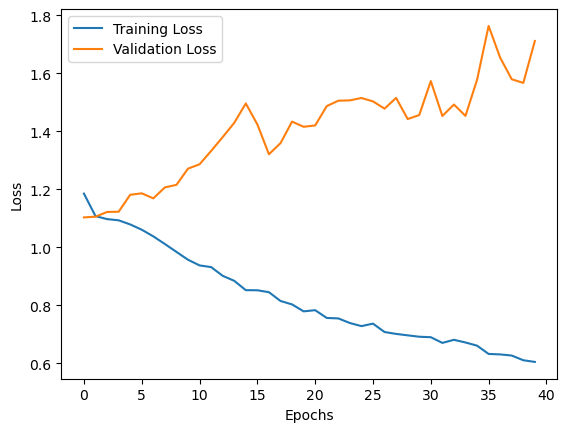

In [18]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

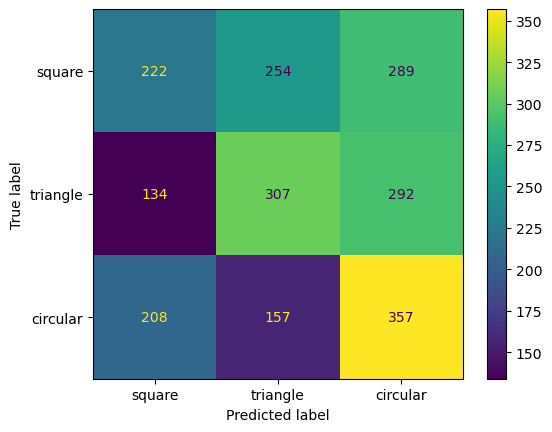

In [19]:
matrix(test_loader,model,['square', 'triangle', 'circular'])

I changed the input features of the first fully connected layer "self.fc1" to accommodate the larger size of the output from the preceding max pooling layer because the spatial dimensions of the convolutional layer outputs are larger with 128x128 inputs, and the number of total elements after flattening is greater. 

# Question 6

Once you have a good model for ```128x128``` without ```fine grain``` redo the experiments with ```fine grain```. How did the performance change? And why?

In [16]:
class SimpleModel(nn.Module):
    def __init__(self, num_channels, num_classes, input_shape=(64, 64)):
        super(SimpleModel, self).__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(65536, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)

    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu', nn.LeakyReLU()),
            ('maxpool', nn.MaxPool2d(2)),
        ]))
        return conv_layer

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
       
        out = out.view(out.size(0), -1)  

        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

In [17]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

train_dataset = FlyingObjects(root= training_img_dir, fine_grained=True , transform= augmentation_transforms)
val_dataset = FlyingObjects(root= validation_img_dir, fine_grained=True, transform= augmentation_transforms)
test_dataset = FlyingObjects(root= testing_img_dir,fine_grained=True, transform= augmentation_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.get_classes())
model = SimpleModel(num_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss, val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=40)

Epoch 1/40, Training Loss: 1.8257094219019279, Validation Loss: 1.8572379594117823
Epoch 2/40, Training Loss: 1.331719570059692, Validation Loss: 1.645799780395669
Epoch 3/40, Training Loss: 1.2324801773096608, Validation Loss: 1.6503928354088688
Epoch 4/40, Training Loss: 1.1176810885249338, Validation Loss: 1.6393738514940503
Epoch 5/40, Training Loss: 1.0158462751228197, Validation Loss: 1.541137029587383
Epoch 6/40, Training Loss: 0.8944278615238392, Validation Loss: 1.764690724476962
Epoch 7/40, Training Loss: 0.8044842087765359, Validation Loss: 1.9553302711164449
Epoch 8/40, Training Loss: 0.7378695397514158, Validation Loss: 1.6886040358476235
Epoch 9/40, Training Loss: 0.5913026949808353, Validation Loss: 1.761954440827101
Epoch 10/40, Training Loss: 0.5192467984757153, Validation Loss: 1.628757398732951
Epoch 11/40, Training Loss: 0.44115737206673467, Validation Loss: 1.5464470732799718
Epoch 12/40, Training Loss: 0.37924894204797294, Validation Loss: 1.3830291819824299
Epoch

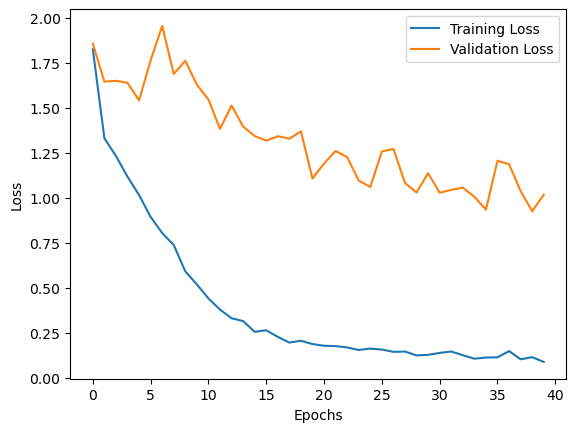

In [18]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

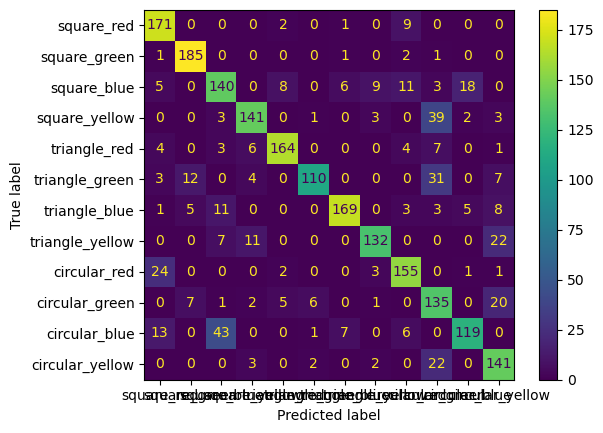

In [20]:
class_names = ['square_red', 'square_green', 'square_blue', 'square_yellow', 
               'triangle_red', 'triangle_green', 'triangle_blue', 'triangle_yellow', 
               'circular_red', 'circular_green', 'circular_blue', 'circular_yellow']

matrix(test_loader, model, class_names)


The confusion matrix shows a high number of correct predictions in the fine-grained model. Plus decreasing loss over epochs


WHY? Because the model learned more detailed features that distinguish not just shapes, but also colors. This requires the model to capture a more complex representation of the input data.





# Question 7
Change the model and dataset to predict both shape and color of the flying object separately. Hint: The model may have 2 output heads. One should predict the color and another should predict the shape. Report the changes you made along with the results. 

In [49]:
class FlyingObjects(torch.utils.data.Dataset):
    """Dataset to Flying Object Dataset for the classification task.
       The label information is encoded on the filename. This version extracts separate labels for shape and color.
    """
    def __init__(self, root, transform=None):
        super(FlyingObjects, self).__init__()
        self.root = root
        self.transform = transform

        self.shape_classes = ['square', 'triangle', 'circular']
        self.color_classes = ['red', 'green', 'blue', 'yellow']

        self.images = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.root + '/image')) for f in fn if f.endswith(".png")]
        self.images.sort()

        self.labels = [self.__extract_label(f) for f in self.images]

    def __extract_label(self, image_file):
        """Extract label from image_file name"""
        path, img_name = os.path.split(image_file)
        names = img_name.split(".")[0].split("_")
        shape_label = self.shape_classes.index(names[1])  
        color_label = self.color_classes.index(names[2])
        return shape_label, color_label

    def __getitem__(self, index):
        x = imageio.imread(self.images[index])
        x = Image.fromarray(x)  
        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(np.array(x)).float()

        shape_label, color_label = self.labels[index]
        return x, shape_label, color_label

    def __len__(self):
        return len(self.images)


In [50]:
class SimpleModel(nn.Module):
    def __init__(self, num_channels, num_shapes, num_colors, input_shape=(64, 64)):
        super(SimpleModel, self).__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc_common = nn.Linear(32 * 32 * 64, 128)
        self.fc_shape = nn.Linear(128, num_shapes)
        self.fc_color = nn.Linear(128, num_colors)
        self.drop = nn.Dropout(0.5)

    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu', nn.LeakyReLU()),
            ('maxpool', nn.MaxPool2d(2)),
        ]))
        return conv_layer

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)

        out = out.view(out.size(0), -1)
        out = self.fc_common(out)
        out = self.drop(out)

        shape_out = self.fc_shape(out)
        color_out = self.fc_color(out)

        return shape_out, color_out


In [51]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.to(device)
    training_loss = []
    validation_loss = []
    val_accuracy_shape = []
    val_accuracy_color = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels_shape, labels_color in train_loader:
            images, labels_shape, labels_color = images.to(device), labels_shape.to(device), labels_color.to(device)
            optimizer.zero_grad()
            outputs_shape, outputs_color = model(images)

            loss_shape = criterion(outputs_shape, labels_shape)
            loss_color = criterion(outputs_color, labels_color)
            loss = loss_shape + loss_color

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_loss.append(running_loss / len(train_loader))

        model.eval()
        running_val_loss = 0.0
        all_labels_shape = []
        all_labels_color = []
        all_preds_shape = []
        all_preds_color = []

        with torch.no_grad():
            for images, labels_shape, labels_color in val_loader:
                images = images.to(device)
                labels_shape = labels_shape.to(device)
                labels_color = labels_color.to(device)

                outputs_shape, outputs_color = model(images)

                loss_shape = criterion(outputs_shape, labels_shape)
                loss_color = criterion(outputs_color, labels_color)
                loss = loss_shape + loss_color
                running_val_loss += loss.item()

                all_labels_shape.extend(labels_shape.cpu().numpy())
                all_labels_color.extend(labels_color.cpu().numpy())
                all_preds_shape.extend(torch.argmax(outputs_shape, 1).cpu().numpy())
                all_preds_color.extend(torch.argmax(outputs_color, 1).cpu().numpy())

        accuracy_shape = accuracy_score(all_labels_shape, all_preds_shape)
        accuracy_color = accuracy_score(all_labels_color, all_preds_color)
        val_accuracy_shape.append(accuracy_shape)
        val_accuracy_color.append(accuracy_color)

        validation_loss.append(running_val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss[-1]}, Validation Loss: {validation_loss[-1]}, "
              f"Shape Accuracy: {accuracy_shape}, Color Accuracy: {accuracy_color}")

    return training_loss, validation_loss, val_accuracy_shape, val_accuracy_color


In [52]:
train_dataset = FlyingObjects(root=training_img_dir, transform=augmentation_transforms)
val_dataset = FlyingObjects(root=validation_img_dir, transform=augmentation_transforms)
test_dataset = FlyingObjects(root=testing_img_dir, transform=augmentation_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_channels = 3 
num_shapes = len(train_dataset.shape_classes)
num_colors = len(train_dataset.color_classes)

model = SimpleModel(num_channels, num_shapes, num_colors)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 40  

train_loss, val_loss, val_accuracy_shape, val_accuracy_color = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/40, Training Loss: 1.6672153159932048, Validation Loss: 1.9013684257655077, Shape Accuracy: 0.27710843373493976, Color Accuracy: 0.7269076305220884
Epoch 2/40, Training Loss: 1.3730102686052126, Validation Loss: 1.6457534046240256, Shape Accuracy: 0.3070058009817046, Color Accuracy: 0.8357875948237394
Epoch 3/40, Training Loss: 1.2655668666580786, Validation Loss: 1.6414335873765005, Shape Accuracy: 0.30655957161981257, Color Accuracy: 0.8393574297188755
Epoch 4/40, Training Loss: 1.2095725675248115, Validation Loss: 1.5469876989512377, Shape Accuracy: 0.32396251673360105, Color Accuracy: 0.8683623382418563
Epoch 5/40, Training Loss: 1.1195205662806125, Validation Loss: 1.5536585173136752, Shape Accuracy: 0.3471664435519857, Color Accuracy: 0.8848728246318608
Epoch 6/40, Training Loss: 1.0351685225787768, Validation Loss: 1.616039321875908, Shape Accuracy: 0.34805890227576974, Color Accuracy: 0.8879964301651049
Epoch 7/40, Training Loss: 0.9424499858797124, Validation Loss: 1.5

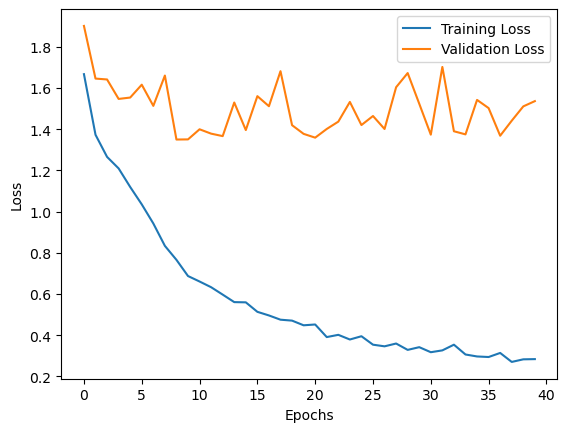

In [53]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
def matrix(loader, net, classes, prediction_type='shape'):
    y_pred = []
    y_true = []
    net.to(device)

    with torch.no_grad():
        for inputs, labels_shape, labels_color in loader:
            inputs = inputs.to(device)
            if prediction_type == 'shape':
                labels = labels_shape.to(device)
            elif prediction_type == 'color':
                labels = labels_color.to(device)
            else:
                raise ValueError("Invalid prediction_type. Choose 'shape' or 'color'.")

            outputs = net(inputs)
            if prediction_type == 'shape':
                predicted = torch.argmax(outputs[0], 1)
            else:
                predicted = torch.argmax(outputs[1], 1)

            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    cf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=classes)
    disp.plot()
    plt.show()


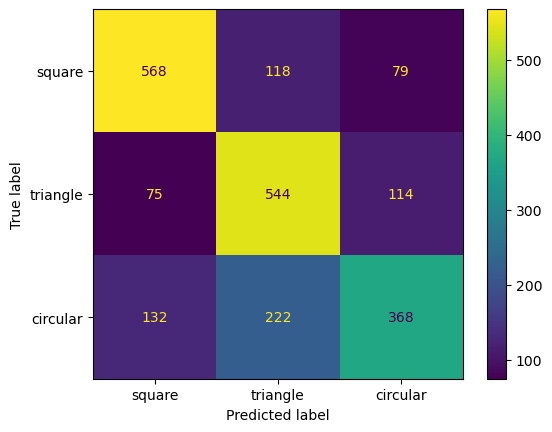

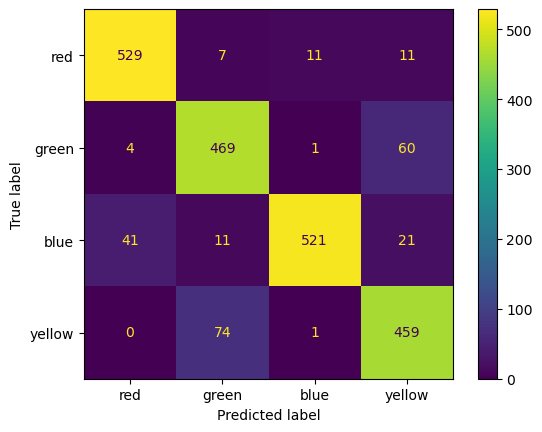

In [58]:
matrix(test_loader, model, ['square', 'triangle', 'circular'], prediction_type='shape')
matrix(test_loader, model, ['red', 'green', 'blue', 'yellow'], prediction_type='color')

I adjusted FlyingObjects dataset class and the SimpleModel class to handle two outputs instead of one.
for training, The loss is calculated separately for both shape and color predictions and then summed to get a total loss which is used to update the model's weights.

Results 
the training loss continued to decrease, indicating that the model was learning from the training data.
The validation loss also decreased but with some fluctuation.

The shape confusion matrix: each shape class was mostly predicted correctly, but there are noticeable misclassifications.
The color confusion matrix: the model was able to learn to classify colors fairly well, although, there are misclassifications.